In [2]:
Pkg.add("JLD")
using JLD

INFO: Cloning cache of Blosc from https://github.com/stevengj/Blosc.jl.git
INFO: Cloning cache of HDF5 from https://github.com/JuliaIO/HDF5.jl.git
INFO: Cloning cache of JLD from https://github.com/JuliaIO/JLD.jl.git
INFO: Cloning cache of LegacyStrings from https://github.com/JuliaArchive/LegacyStrings.jl.git
INFO: Installing Blosc v0.3.0
INFO: Installing HDF5 v0.8.8
INFO: Installing JLD v0.8.3
INFO: Installing LegacyStrings v0.3.0
INFO: Building Blosc
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  130k  100  130k    0     0  52777      0  0:00:02  0:00:02 --:--:--  639k
INFO: Building Homebrew


Already up-to-date.


INFO: Building HDF5


==> Installing szip from staticfloat/juliatranslated
==> Downloading https://homebrew.bintray.com/bottles/szip-2.1.1.sierra.bottle.tar.gz
Already downloaded: /Users/manvithaponnapati/Library/Caches/Homebrew.jl/szip-2.1.1.sierra.bottle.tar.gz
==> Pouring szip-2.1.1.sierra.bottle.tar.gz
🍺  /Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/Cellar/szip/2.1.1: 11 files, 110.1KB


==> Installing hdf5 from staticfloat/juliatranslated
==> Downloading https://homebrew.bintray.com/bottles/hdf5-1.10.1_2.sierra.bottle.tar.gz
Already downloaded: /Users/manvithaponnapati/Library/Caches/Homebrew.jl/hdf5-1.10.1_2.sierra.bottle.tar.gz
==> Pouring hdf5-1.10.1_2.sierra.bottle.tar.gz
🍺  /Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/Cellar/hdf5/1.10.1_2: 265 files, 14.6MB


INFO: Package database updated
INFO: Precompiling module JLD.


In [1]:
Pkg.add("Images")

INFO: Package Images is already installed


In [3]:
using Images

GROUND_TRUTH_FOLDER = "/Users/manvithaponnapati/RAISR/train_data/ground_truth/"
LOW_RES_FOLDER = "/Users/manvithaponnapati/RAISR/train_data/low_res/"
INTERPOLATED_FOLDER = "/Users/manvithaponnapati/RAISR/train_data/interpolated/"

"/Users/manvithaponnapati/RAISR/train_data/interpolated/"

In [1]:
Pkg.add("ImageMagick")

INFO: Cloning cache of ImageMagick from https://github.com/JuliaIO/ImageMagick.jl.git
INFO: Installing ImageMagick v0.5.0
INFO: Building Homebrew


Already up-to-date.


INFO: Building FFTW
INFO: Building SpecialFunctions
INFO: Building ImageMagick


==> Downloading https://homebrew.bintray.com/bottles/xz-5.2.3.sierra.bottle.tar.gz
Already downloaded: /Users/manvithaponnapati/Library/Caches/Homebrew.jl/xz-5.2.3.sierra.bottle.tar.gz
==> Pouring xz-5.2.3.sierra.bottle.tar.gz
🍺  /Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/Cellar/xz/5.2.3: 92 files, 1.4MB


==> Installing libpng from staticfloat/juliatranslated
==> Downloading https://homebrew.bintray.com/bottles/libpng-1.6.34.sierra.bottle.tar.gz
Already downloaded: /Users/manvithaponnapati/Library/Caches/Homebrew.jl/libpng-1.6.34.sierra.bottle.tar.gz
==> Pouring libpng-1.6.34.sierra.bottle.tar.gz
🍺  /Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/Cellar/libpng/1.6.34: 26 files, 1.2MB


==> Installing freetype from staticfloat/juliatranslated
==> Downloading https://homebrew.bintray.com/bottles/freetype-2.8.1.sierra.bottle.tar.gz
Already downloaded: /Users/manvithaponnapati/Library/Caches/Homebrew.jl/freetype-2.8.1.sierra.bottle.tar.gz
==> Pouring freetype-2.8.1.sierra.bottle.tar.gz
🍺  /Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/Cellar/freetype/2.8.1: 63 files, 2.6MB


==> Installing jpeg from staticfloat/juliatranslated
==> Downloading https://homebrew.bintray.com/bottles/jpeg-9b.sierra.bottle.tar.gz
Already downloaded: /Users/manvithaponnapati/Library/Caches/Homebrew.jl/jpeg-9b.sierra.bottle.tar.gz
==> Pouring jpeg-9b.sierra.bottle.tar.gz
🍺  /Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/Cellar/jpeg/9b: 20 files, 724.1KB


==> Installing libtiff from staticfloat/juliatranslated
==> Downloading https://homebrew.bintray.com/bottles/libtiff-4.0.9.sierra.bottle.tar.gz
Already downloaded: /Users/manvithaponnapati/Library/Caches/Homebrew.jl/libtiff-4.0.9.sierra.bottle.tar.gz
==> Pouring libtiff-4.0.9.sierra.bottle.tar.gz
🍺  /Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/Cellar/libtiff/4.0.9: 246 files, 3.5MB


==> Installing libtool from staticfloat/juliatranslated
==> Downloading https://homebrew.bintray.com/bottles/libtool-2.4.6_1.sierra.bottle.tar.gz
Already downloaded: /Users/manvithaponnapati/Library/Caches/Homebrew.jl/libtool-2.4.6_1.sierra.bottle.tar.gz
==> Pouring libtool-2.4.6_1.sierra.bottle.tar.gz
==> Caveats
In order to prevent conflicts with Apple's own libtool we have prepended a "g"
so, you have instead: glibtool and glibtoolize.
==> Summary
🍺  /Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/Cellar/libtool/2.4.6_1: 70 files, 3.7MB


==> Installing imagemagick@6 from staticfloat/juliatranslated
==> Downloading https://homebrew.bintray.com/bottles/imagemagick@6-6.9.9-26.sierra.bottle.tar.gz
Already downloaded: /Users/manvithaponnapati/Library/Caches/Homebrew.jl/imagemagick@6-6.9.9-26.sierra.bottle.tar.gz
==> Pouring imagemagick@6-6.9.9-26.sierra.bottle.tar.gz
==> Caveats
This formula is keg-only, which means it was not symlinked into /Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr,
because this is an alternate version of another formula.

If you need to have this software first in your PATH run:
  echo 'export PATH="/Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/opt/imagemagick@6/bin:$PATH"' >> ~/.bash_profile

For compilers to find this software you may need to set:
    LDFLAGS:  -L/Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/opt/imagemagick@6/lib
    CPPFLAGS: -I/Users/manvithaponnapati/.julia/v0.6/Homebrew/deps/usr/opt/imagemagick@6/include
For pkg-config to find this software you may nee

INFO: Package database updated


INFO: Precompiling module ImageMagick.


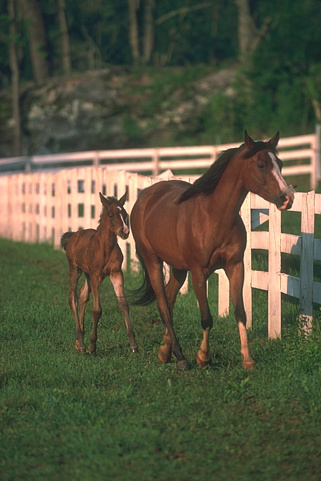

In [4]:
#High Resolution Image
high_res_im = load(GROUND_TRUTH_FOLDER*"113009.jpg")

In [5]:
w,h = size(high_res_im)
println("Image dimensions $w and $h")

Image dimensions 481 and 321


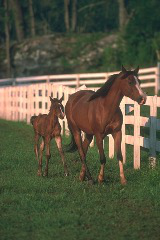

In [6]:
scale_factor = 2
scaled_dow_im = load(LOW_RES_FOLDER*"113009.jpg")
low_res_im = load(INTERPOLATED_FOLDER*"113009.jpg")
scaled_dow_im

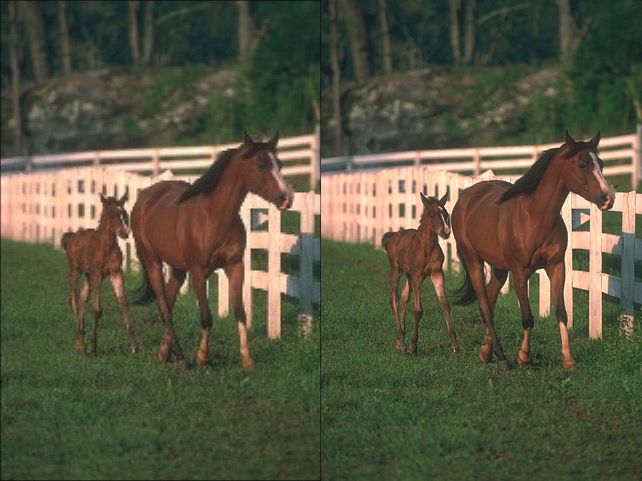

In [7]:
[low_res_im high_res_im]

In [8]:
Pkg.add("Distributions")

INFO: Cloning cache of Distributions from https://github.com/JuliaStats/Distributions.jl.git
INFO: Cloning cache of PDMats from https://github.com/JuliaStats/PDMats.jl.git
INFO: Cloning cache of QuadGK from https://github.com/JuliaMath/QuadGK.jl.git
INFO: Cloning cache of Rmath from https://github.com/JuliaStats/Rmath.jl.git
INFO: Cloning cache of StatsFuns from https://github.com/JuliaStats/StatsFuns.jl.git
INFO: Installing Distributions v0.15.0
INFO: Installing PDMats v0.7.1
INFO: Installing QuadGK v0.1.3
INFO: Installing Rmath v0.3.0
INFO: Installing StatsFuns v0.5.0
INFO: Building SpecialFunctions
INFO: Building Rmath
INFO: Attempting to create directory /Users/manvithaponnapati/.julia/v0.6/Rmath/deps/downloads
INFO: Downloading file https://github.com/JuliaLang/Rmath-julia/archive/v0.2.0.tar.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   129    0   129    0     0

/Applications/Xcode.app/Contents/Developer/usr/bin/make -C src
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c bd0.c -o bd0.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c bessel_i.c -o bessel_i.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c bessel_j.c -o bessel_j.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c bessel_k.c -o bessel_k.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c bessel_y.c -o bessel_y.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c beta.c -o beta.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c callback.c -o callback.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c chebyshev.c -o chebyshev.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c choose.c -o choose.o
gcc  -Wall -

gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c qlnorm.c -o qlnorm.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c qlogis.c -o qlogis.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c qnbeta.c -o qnbeta.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c qnbinom.c -o qnbinom.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c qnchisq.c -o qnchisq.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c qnf.c -o qnf.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c qnorm.c -o qnorm.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c qnt.c -o qnt.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c qpois.c -o qpois.o
gcc  -Wall -O3 -fPIC -DMATHLIB_STANDALONE   -std=gnu99 -I../include -DNDEBUG -c qt.c -o qt.o
gcc  -Wall

INFO: Changing directory to /Users/manvithaponnapati/.julia/v0.6/Rmath/deps/src/Rmath-julia-0.2.0
INFO: Package database updated


In [15]:
using Distributions
#Calculate image properties
#Taking 3x3 patches on the imahes 
Qangle = 24
Qstrength = 3
Qcoherence = 3
patchsize = 3
Q = zeros((Qangle, Qstrength, Qcoherence, scale_factor*scale_factor, patchsize*patchsize, patchsize*patchsize))
V = zeros((Qangle, Qstrength, Qcoherence, scale_factor*scale_factor, patchsize*patchsize))
mark = zeros((Qstrength*Qcoherence, Qangle, scale_factor*scale_factor))

start_index = Int(ceil(patchsize/2))
weights_matrix = rand(Normal(0, 2), patchsize*patchsize)
weights_matrix = Array(Diagonal(weights_matrix))
#the really really twosted conversions on JuliaImages
filenames = readdir(INTERPOLATED_FOLDER)
for file in filenames
    if (contains("$file", ".jpg")) == true
        println("File nm: $file")
        low_res_im = load(INTERPOLATED_FOLDER*file)
        ground_truth_im = load(GROUND_TRUTH_FOLDER*file)
        
        colorview_rgb = convert(Array{Float64},channelview(low_res_im))
        color_ve = 0.21*colorview_rgb[1,:,:]+ 0.72*colorview_rgb[2,:,:]+0.07*colorview_rgb[3,:,:]
        
        colorview_rgb_gt = convert(Array{Float64},channelview(ground_truth_im))
        color_ve_gt = 0.21*colorview_rgb_gt[1,:,:]+ 0.72*colorview_rgb_gt[2,:,:]+0.07*colorview_rgb_gt[3,:,:]
        w,h = size(color_ve)
        for row in start_index:Int(w)-start_index
            for col in start_index:Int(h)-start_index
                patch = color_ve[row-1:row+1,col-1:col+1]
                gx,gy = imgradients(patch)
                gx = reshape(gx,patchsize*patchsize,1)
                gy = reshape(gy,patchsize*patchsize,1)
                GT = transpose([gx gy])
                GTWG = GT*weights_matrix*transpose(GT)
                eigen_max = eigmax(GTWG)
                eigen_min = eigmin(GTWG)
                eigen_vector_max = eigvecs(GTWG)[:,1]
                eigen_vector_min = eigvecs(GTWG)[:,2]
                gradient_angle = atan2(eigen_vector_max[2],eigen_vector_max[1])
                if gradient_angle < 0
                    gradient_angle = gradient_angle + pi
                end
                lamda = abs(sqrt(complex(eigen_max)))/Qstrength
                u =(sqrt(complex(eigen_max)) -  sqrt(complex(eigen_min)))/(sqrt(complex(eigen_max)) +  sqrt(complex(eigen_min)))/Qcoherence
                angle = floor(gradient_angle/pi*Qangle)


                if lamda < 0.0001
                    strength = 1
                elseif lamda > 0.001
                    strength = 3
                else
                    strength = 2
                end

                u = abs(u)
                if u < 0.25
                    coherence = 1
                elseif u > 0.5
                    coherence = 3
                else
                    coherence = 2
                end


                # Bound the output to the desired ranges
                if angle > 23
                    angle = 23
                elseif angle <= 0
                    angle = 1
                end
                angle = Int(angle)
                # Get pixel type
                pixeltype = ((row-start_index) % scale_factor) * scale_factor + ((col-start_index) % scale_factor)
                pixelHR = color_ve_gt[row,col]
                # Compute A'A and A'b
                wp,hp = size(patch)
                patch_1 = reshape(patch,wp*hp,1)
                patch = reshape(patch,wp*hp)
                ATA = dot(transpose(patch_1),patch_1)
                ATb = patch*pixelHR
                Q[angle,strength,coherence,pixeltype+1,:,:] += ATA
                V[angle,strength,coherence,pixeltype+1,:] += ATb
                mark[coherence*3+strength, angle, pixeltype+1] += 1
            end
        end

    end
end



File nm: 100007.jpg


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] imgradients(::Array{Float64,2}) at /Users/manvithaponnapati/.julia/v0.6/ImageFiltering/src/specialty.jl:50
 [3] macro expansion at ./In[15]:32 [inlined]
 [4] anonymous at ./<missing>:?
 [5] include_string(::String, ::String) at ./loading.jl:522
 [6] include_string(::Module, ::String, ::String) at /Users/manvithaponnapati/.julia/v0.6/Compat/src/Compat.jl:174
 [7] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/manvithaponnapati/.julia/v0.6/IJulia/src/execute_request.jl:154
 [8] eventloop(::ZMQ.Socket) at /Users/manvithaponnapati/.julia/v0.6/IJulia/src/eventloop.jl:8
 [9] (::IJulia.##14#17)() at ./task.jl:335
while loading In[15], in expression starting on line 17


File nm: 100039.jpg
File nm: 100075.jpg
File nm: 100080.jpg
File nm: 100098.jpg
File nm: 100099.jpg
File nm: 10081.jpg
File nm: 101027.jpg
File nm: 101084.jpg
File nm: 102062.jpg
File nm: 103006.jpg
File nm: 103029.jpg
File nm: 103041.jpg
File nm: 103078.jpg
File nm: 104010.jpg
File nm: 104022.jpg
File nm: 104055.jpg
File nm: 105019.jpg
File nm: 105027.jpg
File nm: 105053.jpg
File nm: 106005.jpg
File nm: 106020.jpg
File nm: 106025.jpg
File nm: 106047.jpg
File nm: 107014.jpg
File nm: 107045.jpg
File nm: 107072.jpg
File nm: 108004.jpg
File nm: 108036.jpg
File nm: 108041.jpg
File nm: 108069.jpg
File nm: 108073.jpg
File nm: 109034.jpg
File nm: 109055.jpg
File nm: 112056.jpg
File nm: 112082.jpg
File nm: 112090.jpg
File nm: 113009.jpg
File nm: 113016.jpg
File nm: 113044.jpg
File nm: 117025.jpg
File nm: 117054.jpg
File nm: 118015.jpg
File nm: 118020.jpg
File nm: 118031.jpg
File nm: 118035.jpg
File nm: 118072.jpg
File nm: 120003.jpg
File nm: 12003.jpg
File nm: 120093.jpg
File nm: 12074.jpg
Fil

In [20]:
println("Calculating filterS")
# Conjugate Gradients Solver
function cgls(A, b)
   
    height, width = size(A)
    
    x = zeros((height))
    while(true)
        sumA = sum(A)
        
        if (sumA < 100)
            break
        end
        if (det(A) < 1)
            A = A + eye(height, width) * sumA * 0.000000005
        else
            x = inv(A)*b
            break
        end
    end
    println("Return $x")
    return x
end

h = zeros((Qangle, Qstrength, Qcoherence, scale_factor*scale_factor, patchsize*patchsize))
operationcount = 0
totaloperations = scale_factor * scale_factor * Qangle * Qstrength * Qcoherence
for pixeltype in range(1, scale_factor*scale_factor)
    for angle in range(1, Qangle)
        for strength in range(1, Qstrength)
            for coherence in range(1, Qcoherence)
                println(" K: index $pixeltype,$angle, $strength, $coherence")
                operationcount += 1
                h[angle,strength,coherence,pixeltype,:] = cgls(Q[angle,strength,coherence,pixeltype,:,:], V[angle,strength,coherence,pixeltype,:])
            end
        end
    end
end

Calculating filterS
 K: index 1,1, 1, 1
Return [0.0121287, 0.0121287, 0.0110704, 0.0162174, 0.0121287, 0.0110704, 0.0121287, 0.0121287, 0.0121384]
 K: index 1,1, 1, 2
Return [0.0123484, 0.0123484, 0.0123484, 0.0123484, 0.0123484, 0.0123484, 0.0123484, 0.0123484, 0.0123484]
 K: index 1,1, 1, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 1,1, 2, 1
Return [-0.100533, -0.0295419, 0.238548, -0.00759108, 0.283437, 0.319982, -0.348752, 0.371333, -0.615692]
 K: index 1,1, 2, 2
Return [0.0265513, 0.0599102, -0.0536363, 0.0561708, 0.108749, -0.0608376, 0.0508629, 0.0233275, -0.0999104]
 K: index 1,1, 2, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 1,1, 3, 1
Return [-1548.63, -95.0103, -2394.63, 1493.49, 3667.25, 618.923, -930.204, 665.73, -1476.81]
 K: index 1,1, 3, 2
Return [-7248.38, -1565.77, -4761.69, 1587.9, 7506.25, 3997.46, -2647.44, 3184.15, -52.3641]
 K: index 1,1, 3, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 1,2, 1, 1
Return

Return [0.0123988, 0.0116456, 0.012376, 0.0123988, 0.0123481, 0.0123988, 0.0123709, 0.0123481, 0.0123988]
 K: index 1,11, 1, 2
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 1,11, 1, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 1,11, 2, 1
Return [-0.0115118, 0.112824, 0.0321035, -0.0663887, 0.0592719, 0.0359588, -0.111387, 0.0240115, 0.0363273]
 K: index 1,11, 2, 2
Return [-0.007776, -0.0246977, 0.0874379, 8.36068e-5, -0.027966, 0.0686116, 0.00797425, -0.0314791, 0.0389678]
 K: index 1,11, 2, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 1,11, 3, 1
Return [-732.662, 1763.11, -1502.71, -579.87, 2435.83, -1103.1, -855.29, 1911.99, -1337.18]
 K: index 1,11, 3, 2
Return [-8355.69, 6613.96, 2315.04, -8721.24, 6542.65, 2384.08, -9094.27, 6093.94, 2221.64]
 K: index 1,11, 3, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 1,12, 1, 1
Return [0.0132533, 0.0132533, 0.00921778, 0.0132533, 0.0132533, 0.00921778, 0.0132533, 0.0

Return [0.0117675, 0.0117675, 0.0117675, 0.0117675, 0.0117207, 0.0117675, 0.0117207, 0.0117207, 0.0117207]
 K: index 1,21, 1, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 1,21, 2, 1
Return [0.171379, 0.233437, 0.252812, 0.0725734, -0.224952, 0.00261202, -0.149313, -0.122383, -0.124966]
 K: index 1,21, 2, 2
Return [0.0150503, 0.0237035, 0.0238209, 0.0196507, -0.0104677, 0.0624796, -0.00177855, 0.00377508, -0.0250671]
 K: index 1,21, 2, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 1,21, 3, 1
Return [-1689.7, -194.315, -1560.9, 1150.61, 3254.98, 801.131, -762.653, 414.451, -1413.48]
 K: index 1,21, 3, 2
Return [-454.845, 21.169, -282.705, 254.06, 780.984, 364.498, -280.17, -31.7568, -371.124]
 K: index 1,21, 3, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 1,22, 1, 1
Return [0.0119567, 0.0119567, 0.0119567, 0.0119567, 0.0119736, 0.0119567, 0.0119567, 0.0153421, 0.0119736]
 K: index 1,22, 1, 2
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

Return [0.0124852, 0.010874, 0.0125115, 0.0124852, 0.0125115, 0.0124852, 0.0124852, 0.0125115, 0.0124852]
 K: index 2,11, 1, 2
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 2,11, 1, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 2,11, 2, 1
Return [-0.088575, 0.114309, 0.0983118, -0.0468107, -0.0446755, 0.0820189, -0.0228256, -0.0717109, 0.0911309]
 K: index 2,11, 2, 2
Return [0.0211996, 0.0119264, -0.00397494, 0.0222071, -0.00011433, 0.00568477, 0.0315773, -0.00624971, 0.0289795]
 K: index 2,11, 2, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 2,11, 3, 1
Return [-62.9462, 1217.35, -1245.94, -151.446, 1412.36, -1131.4, -284.041, 1379.7, -1133.52]
 K: index 2,11, 3, 2
Return [-6987.63, 6291.28, 1188.64, -7413.8, 6211.78, 1321.05, -7838.73, 5868.86, 1358.66]
 K: index 2,11, 3, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 2,12, 1, 1
Return [0.0136768, 0.0137089, 0.00768844, 0.0137089, 0.0136768, 0.00768844, 0.0137089

Return [0.011931, 0.011931, 0.011931, 0.011931, 0.0125272, 0.011931, 0.0125272, 0.0125272, 0.0125272]
 K: index 2,21, 1, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 2,21, 2, 1
Return [0.0364639, 0.0132619, 0.163734, 0.133947, 0.0324264, 0.0290207, -0.196553, 0.0261879, -0.127282]
 K: index 2,21, 2, 2
Return [-0.0101042, -0.00696544, -0.0288941, -0.0116087, 0.0443084, -0.0104736, 0.0363065, 0.0374711, 0.0610985]
 K: index 2,21, 2, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 2,21, 3, 1
Return [-407.61, 410.819, -778.565, -255.23, 885.649, -472.231, -195.505, 1125.64, -312.859]
 K: index 2,21, 3, 2
Return [-399.925, 120.341, -1085.32, -182.596, 613.807, -300.779, -36.1904, 900.137, 370.637]
 K: index 2,21, 3, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 2,22, 1, 1
Return [0.0122639, 0.0122639, 0.0122639, 0.0122639, 0.0122639, 0.0122639, 0.0122639, 0.0130599, 0.0122639]
 K: index 2,22, 1, 2
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

Return [0.0121313, 0.0134182, 0.0121313, 0.0121313, 0.0121313, 0.0121313, 0.012363, 0.0120386, 0.0120386]
 K: index 3,11, 1, 2
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 3,11, 1, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 3,11, 2, 1
Return [-0.0654839, 0.186226, -0.0301876, -0.0791005, 0.0122009, 0.0730341, -0.0712933, -0.00747594, 0.0932513]
 K: index 3,11, 2, 2
Return [0.00917619, 0.0407111, -0.0172688, 0.00759503, 0.0237199, 0.00799919, 0.00216314, 0.0151486, 0.0219087]
 K: index 3,11, 2, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 3,11, 3, 1
Return [231.405, -262.565, -794.859, 908.129, 373.687, -260.216, 308.963, -38.9347, -465.497]
 K: index 3,11, 3, 2
Return [79.3032, -46.9854, -245.577, 21.3537, 72.9507, 49.2211, -279.508, 54.8312, 294.521]
 K: index 3,11, 3, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 3,12, 1, 1
Return [0.013319, 0.013319, 0.00896449, 0.013319, 0.013319, 0.00896449, 0.013319, 0

Return [0.0124737, 0.0124737, 0.0124737, 0.0124737, 0.0118637, 0.0124737, 0.0118637, 0.0118637, 0.0118637]
 K: index 3,21, 1, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 3,21, 2, 1
Return [0.154009, 0.307062, 0.339431, 0.083493, -0.39688, 0.34958, -0.23999, -0.174341, -0.311137]
 K: index 3,21, 2, 2
Return [0.0289736, 0.0148634, -4.02468e-6, 0.0192408, 0.0327325, 0.000115869, 0.0130414, 0.00707655, -0.00484848]
 K: index 3,21, 2, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 3,21, 3, 1
Return [-1421.3, -1082.26, -772.205, 1371.49, 1626.64, 1561.68, -358.596, -381.332, -544.005]
 K: index 3,21, 3, 2
Return [-82.399, -321.241, -622.295, 1164.4, 885.101, 400.149, 49.4211, -447.1, -1025.92]
 K: index 3,21, 3, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 3,22, 1, 1
Return [0.0118635, 0.0118635, 0.0118635, 0.0118797, 0.0118635, 0.0118635, 0.0118635, 0.0160678, 0.0118797]
 K: index 3,22, 1, 2
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

Return [0.012292, 0.0122807, 0.012292, 0.012292, 0.012292, 0.012292, 0.012292, 0.012292, 0.012292]
 K: index 4,11, 1, 2
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 4,11, 1, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 4,11, 2, 1
Return [-0.0741984, 0.146909, -0.00844128, -0.100151, -0.00293851, 0.13427, -0.0782323, -0.0486493, 0.142653]
 K: index 4,11, 2, 2
Return [-0.00244046, 0.0146502, 0.0485818, -0.0115275, 0.00520771, 0.0397555, -0.0204015, 0.011706, 0.0257031]
 K: index 4,11, 2, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 4,11, 3, 1
Return [277.858, -37.8088, -444.178, 263.991, 51.0236, -210.653, 125.765, 80.7508, -106.638]
 K: index 4,11, 3, 2
Return [299.987, -34.3845, -478.12, 181.231, 49.4123, -164.973, -26.7867, 96.5688, 77.175]
 K: index 4,11, 3, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 4,12, 1, 1
Return [0.0140128, 0.0145483, 0.00539747, 0.0145483, 0.0140128, 0.00540928, 0.0145483, 0.014012

Return [0.012275, 0.0122634, 0.0122634, 0.012453, 0.0121991, 0.0121991, 0.0121991, 0.0121991, 0.0121991]
 K: index 4,21, 1, 2
Return [0.0120234, 0.0120234, 0.0120234, 0.0120234, 0.0122197, 0.0120234, 0.0122197, 0.0122197, 0.0122197]
 K: index 4,21, 1, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 4,21, 2, 1
Return [0.105689, 0.21549, 0.133954, -0.00323174, -0.216716, 0.14614, -0.181644, -0.131678, 0.0431885]
 K: index 4,21, 2, 2
Return [0.00610407, 0.00228093, 0.0178115, -0.0208162, 0.0485964, 0.0254735, 0.0186006, 0.0126142, 0.000497936]
 K: index 4,21, 2, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 4,21, 3, 1
Return [-314.43, -168.572, -146.144, -91.1417, 71.0958, 161.717, -32.0909, 205.456, 314.221]
 K: index 4,21, 3, 2
Return [513.749, -521.874, -1638.76, 668.511, 56.724, -622.642, 700.509, 550.683, 293.206]
 K: index 4,21, 3, 3
Return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 K: index 4,22, 1, 1
Return [0.0122853, 0.0122853, 0.0122853, 

In [17]:
using JLD

In [18]:
save("filters_learned.jld","filters",h)

In [19]:
println(load("filters_learned.jld","filters"))

[0.0121287 -0.100533 -1548.63; 0.0121054 -0.0288014 -917.675; 0.0 -0.111431 -736.317; 0.0 0.33289 -665.076; 0.0 -0.241906 -642.26; 0.0 0.0531296 -366.28; 0.0 0.00196135 -449.579; 0.00915387 0.0343933 -523.229; 0.0 -0.108662 -514.869; 0.0 -0.0519964 -650.154; 0.0123988 -0.0115118 -732.662; 0.0132533 0.0187391 -1024.16; 0.0 -0.0559469 -1164.84; 0.0121071 -0.285897 -1311.3; 0.0 -0.095735 -1372.55; 0.0 0.0993346 -1404.05; 0.0 0.14929 -1687.19; 0.0118929 -0.0702178 -1357.12; 0.0 -0.168446 -1510.77; 0.0124584 0.134583 -1536.24; 0.0 0.171379 -1689.7; 0.0119567 -0.128933 -1889.79; 0.0119477 0.0266169 -1894.53; 0.0 0.0 0.0]

[0.0123484 0.0265513 -7248.38; 0.0129476 -0.0408977 53.853; 0.0 0.0246666 98.5022; 0.0 0.0102828 85.4834; 0.0 0.0101923 118.873; 0.0 0.0129181 54.2066; 0.0156843 -0.0904441 -13.4253; 0.0 0.0241165 -107.721; 0.0 0.014904 -156.506; 0.0 -0.00734849 -657.12; 0.0 -0.007776 -8355.69; 0.0127194 -0.959642 -6226.18; 0.0 0.02289 -1911.78; 0.0115941 0.132002 -541.039; 0.0 0.0180274 -9

[0.0123486 0.0637794 -4053.03; 0.0135682 -0.0346278 111.592; 0.0 0.00356634 11.2997; 0.0 0.0155244 -57.4717; 0.0 0.0188044 -171.278; 0.0 0.0122248 -207.741; 0.0158152 -0.0888968 -249.213; 0.0 0.0241593 -320.197; 0.0 0.0124969 -419.193; 0.0 0.020711 -413.651; 0.0 0.0407111 -46.9854; 0.011896 0.0179513 59.7272; 0.0 0.0147091 459.001; 0.0109971 0.0845468 449.595; 0.0 0.0137855 358.6; 0.0 0.0197985 343.606; 0.0 0.0109876 209.959; 0.0 0.0195105 169.355; 0.012051 0.0464324 134.883; 0.0 -0.0367311 39.78; 0.0124737 0.0148634 -321.241; 0.0 0.0323212 -1622.74; 0.0123913 0.110777 -5440.4; 0.0 0.0 0.0]

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

[0.013791 -0.0409874 90.2774; 0.0121952 0.0558849 126.357; 0.0 0.0620095 105.468; 0.0 0

[0.0162174 -0.00759108 1493.49; 0.0121054 0.0240153 1239.31; 0.0 0.13212 991.465; 0.0 0.306559 774.271; 0.0 0.208165 551.593; 0.0 0.0985926 228.965; 0.0 -0.00235483 118.136; 0.00915387 -0.0375524 -18.2846; 0.0 -0.137629 -120.289; 0.0 0.0339503 -437.976; 0.0123988 -0.0663887 -579.87; 0.0132533 0.00708062 -435.093; 0.0 -0.0680093 -306.487; 0.0121071 -0.20646 -148.5; 0.0 -0.00841705 165.541; 0.0 0.15198 312.645; 0.0 0.0801789 330.274; 0.0123518 -0.0212841 668.381; 0.0 -0.0219199 728.29; 0.0124584 0.0780136 928.76; 0.0 0.0725734 1150.61; 0.0119567 -0.0807469 1336.36; 0.0119477 0.0718095 1360.91; 0.0 0.0 0.0]

[0.0123484 0.0561708 1587.9; 0.0129476 0.0627038 374.909; 0.0 0.0257941 160.818; 0.0 0.0222275 26.1066; 0.0 0.0113324 -142.945; 0.0 0.00992358 -253.22; 0.0156843 -0.082205 -286.696; 0.0 0.0272848 -357.018; 0.0 0.0155075 -283.494; 0.0 -0.00867275 -862.653; 0.0 8.36068e-5 -8721.24; 0.0127194 -0.960008 -5999.85; 0.0 0.0220495 -1259.04; 0.0115941 0.129881 -193.885; 0.0 0.0108176 131.742; 

[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]

[0.0136567 -0.0424932 59.7952; 0.0122157 -0.0827749 79.4113; 0.0 -0.0100892 78.9319; 0.0 -0.00916289 100.879; 0.0121538 0.176638 91.0425; 0.0 -0.00631988 99.1191; 0.0 0.0192778 115.596; 0.00823262 0.0662656 87.1723; 0.0 0.0247837 84.7315; 0.0 0.0865321 55.1174; 0.012292 -0.00293851 51.0236; 0.0140128 0.0450982 45.2968; 0.0 -0.134708 74.4626; 0.0130112 -0.383721 62.7495; 0.0 0.00505783 93.3662; 0.0 0.234433 81.9411; 0.0 -0.0503201 95.2812; 0.0119834 0.162114 107.935; 0.0 0.12666 103.07; 0.0122227 -0.0229898 87.1272; 0.0121991 -0.216716 71.0958; 0.0122853 0.164592 65.2098; 0.0147529 0.0919166 59.6762; 0.0 0.0 0.0]

[0.0123486 0.0845304 62.2176; 0.0141925 -0.0191152 56.3382; 0.0 0

[0.0121287 -0.348752 -930.204; 0.0128825 0.0575545 -1230.04; 0.0 -0.016465 -1303.97; 0.0 -0.292377 -1316.46; 0.0 -0.0434763 -1281.3; 0.0 -0.0244401 -1592.27; 0.0 -0.200899 -1410.4; 0.0380121 -0.5977 -1330.68; 0.0 -0.157173 -994.443; 0.0 -0.076326 -1061.57; 0.0123709 -0.111387 -855.29; 0.0132533 0.0444508 -662.675; 0.0 -0.112158 -567.825; 0.0121071 -0.170853 -519.581; 0.0 -0.00660696 -521.583; 0.0 0.0697566 -457.31; 0.0 0.0192014 -364.815; 0.0123518 -0.0541693 -720.517; 0.0 -0.0319467 -657.064; 0.0115901 -0.191895 -665.055; 0.0 -0.149313 -762.653; 0.0119567 -0.521631 -889.207; 0.0120373 -0.131866 -983.215; 0.0 0.0 0.0]

[0.0123484 0.0508629 -2647.44; 0.0129476 0.0714603 -957.473; 0.0 0.0262533 -422.521; 0.0 0.00534166 -410.221; 0.0 0.0188094 -623.185; 0.0 0.00425718 -629.126; 0.0156843 -0.0912227 -639.906; 0.0 0.0211951 -730.374; 0.0 0.0176614 -524.555; 0.0 -0.0109737 -1170.76; 0.0 0.00797425 -9094.27; 0.0127194 -0.951905 -5848.13; 0.0 0.0310648 -949.689; 0.0115941 0.108529 -171.659; 0.

[0.0136567 -0.247715 -34.8187; 0.0122157 -0.362627 -81.026; 0.0 -0.0194928 -54.6926; 0.0 -0.17214 114.174; 0.0124546 -0.323747 110.99; 0.0 0.0662788 -34.662; 0.0 0.0280391 -191.306; 0.00823262 0.0727971 -503.134; 0.0 -0.0142507 -154.295; 0.0 0.0406872 9.0963; 0.012292 -0.0486493 80.7508; 0.0140128 0.0483495 -39.7011; 0.0 -0.141422 36.7504; 0.0130112 -0.480994 89.9281; 0.0 0.0399708 132.13; 0.0 -0.226112 403.793; 0.0 -0.00297582 395.202; 0.0119834 -0.0323247 97.1616; 0.0 -0.0715268 -51.0312; 0.0122227 0.0012296 -91.9844; 0.0121991 -0.131678 205.456; 0.012676 -0.867897 59.2112; 0.0121878 0.0946909 141.622; 0.0 0.0 0.0]

[0.0123486 0.0997884 -342.638; 0.0141925 0.0149846 -398.965; 0.0 0.0313864 -66.0379; 0.0 0.0105808 -13.3064; 0.0 0.00826057 131.122; 0.0 0.0143811 297.375; 0.0149503 -0.0571234 526.663; 0.0 0.0138994 581.832; 0.0 0.0120022 1452.06; 0.0 0.00683807 547.726; 0.0 0.011706 96.5688; 0.0118459 0.250212 -50.8178; 0.0 0.0255074 -636.823; 0.0137575 0.086322 -1452.81; 0.0 0.0183907 